<a href="https://colab.research.google.com/github/adiazoq/Proyecto-Machine-Learning/blob/main/C%C3%B3digos/MODELO_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================================================================
# PASO 1: IMPORTAR BIBLIOTECAS
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Bibliotecas importadas correctamente")


Bibliotecas importadas correctamente


In [ ]:
# Leer base de datos de excel
from google.colab import files
uploaded = files.upload()
!ls

Saving df_diario_promediado.xlsx to df_diario_promediado (1).xlsx
'df_diario_promediado (1).xlsx'   df_diario_promediado.xlsx   sample_data


In [ ]:
# =============================================================================
# CARGAR E IMPORTAR BASE DE DATOS
# =============================================================================

# Cargar el archivo Excel
df_diario_promediado = pd.read_excel('df_diario_promediado.xlsx')

In [ ]:
#ver la base de datos con print y head
print(df_diario_promediado)

            Dia  TemperaturaPromedio   Año  \
0    2006-01-01            27.579167  2006   
1    2006-01-02            27.875000  2006   
2    2006-01-03            27.754167  2006   
3    2006-01-04            26.141667  2006   
4    2006-01-05            26.841667  2006   
...         ...                  ...   ...   
6742 2024-12-27            28.049936  2024   
6743 2024-12-28            27.626309  2024   
6744 2024-12-29            27.823402  2024   
6745 2024-12-30            27.484852  2024   
6746 2024-12-31            27.265878  2024   

                                         NombreEstacion  \
0                                       FEDEARROZ - AUT   
1                                       FEDEARROZ - AUT   
2                                       FEDEARROZ - AUT   
3                                       FEDEARROZ - AUT   
4                                       FEDEARROZ - AUT   
...                                                 ...   
6742  AEROPUERTO ALFONSO LOPEZ, FE

In [ ]:
# =============================================================================
# PASO 2: CARGAR Y PREPARAR LOS DATOS
# =============================================================================

print("=" * 70)
print("CARGANDO Y PREPARANDO DATOS PARA EL MODELO GRU")
print("=" * 70)

# Tu dataset ya está cargado como df_diario_promediado
print(f"Dimensiones del dataset: {df_diario_promediado.shape}")

# Verificar las columnas disponibles
print(f"Columnas disponibles: {df_diario_promediado.columns.tolist()}")

# Mostrar información básica
print(f"Rango de fechas: {df_diario_promediado['Dia'].min()} a {df_diario_promediado['Dia'].max()}")
print(f"Total de días: {len(df_diario_promediado)}")

# Separar datos de entrenamiento (2006-01-01 a 2020-12-31) y prueba (2021-01-01 a 2024-12-31)
print("\nSeparando datos en conjunto de entrenamiento y prueba...")

# Convertir la columna Dia a datetime para facilitar el filtrado
df_diario_promediado['Dia_datetime'] = pd.to_datetime(df_diario_promediado['Dia'])

# Filtrar datos de entrenamiento (2006-2020)
train_data = df_diario_promediado[df_diario_promediado['Dia_datetime'] <= '2020-12-31']
# Filtrar datos de prueba (2021-2024)
test_data = df_diario_promediado[df_diario_promediado['Dia_datetime'] >= '2021-01-01']

print(f"Datos de entrenamiento (2006-2020): {len(train_data)} días")
print(f"Datos de prueba (2021-2024): {len(test_data)} días")

# Extraer solo la columna de temperatura para el modelo
train_temperatures = train_data['TemperaturaPromedio'].values.astype('float32')
test_temperatures = test_data['TemperaturaPromedio'].values.astype('float32')

print(f"Temperaturas de entrenamiento: {train_temperatures.shape}")
print(f"Temperaturas de prueba: {test_temperatures.shape}")

CARGANDO Y PREPARANDO DATOS PARA EL MODELO GRU
Dimensiones del dataset: (6747, 6)
Columnas disponibles: ['Dia', 'TemperaturaPromedio', 'Año', 'NombreEstacion', 'CodigoEstacion', 'CodigoSensor']
Rango de fechas: 2006-01-01 00:00:00 a 2024-12-31 00:00:00
Total de días: 6747

Separando datos en conjunto de entrenamiento y prueba...
Datos de entrenamiento (2006-2020): 5421 días
Datos de prueba (2021-2024): 1326 días
Temperaturas de entrenamiento: (5421,)
Temperaturas de prueba: (1326,)


In [ ]:
# =============================================================================
# PASO 3: NORMALIZAR LOS DATOS
# =============================================================================

print("\n" + "=" * 70)
print("NORMALIZANDO LOS DATOS")
print("=" * 70)

# Normalizar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustar el scaler solo con los datos de entrenamiento
train_temperatures_scaled = scaler.fit_transform(train_temperatures.reshape(-1, 1))
test_temperatures_scaled = scaler.transform(test_temperatures.reshape(-1, 1))

print(f"Temperaturas entrenamiento - Min: {train_temperatures.min():.2f}, Max: {train_temperatures.max():.2f}")
print(f"Temperaturas entrenamiento escaladas - Min: {train_temperatures_scaled.min():.2f}, Max: {train_temperatures_scaled.max():.2f}")
print(f"Temperaturas prueba escaladas - Min: {test_temperatures_scaled.min():.2f}, Max: {test_temperatures_scaled.max():.2f}")


NORMALIZANDO LOS DATOS
Temperaturas entrenamiento - Min: 18.88, Max: 36.27
Temperaturas entrenamiento escaladas - Min: 0.00, Max: 1.00
Temperaturas prueba escaladas - Min: 0.13, Max: 0.99


In [ ]:
# =============================================================================
# PASO 4: PREPARAR LOS DATOS PARA EL MODELO GRU
# =============================================================================

print("\n" + "=" * 70)
print("PREPARANDO DATOS PARA EL MODELO GRU")
print("=" * 70)

def create_dataset(data, look_back=1):
    """
    Crea conjuntos de datos para el modelo GRU usando ventana deslizante

    Parámetros:
    - data: array de datos normalizados
    - look_back: número de pasos anteriores para predecir el siguiente

    Retorna:
    - X: características (ventanas de look_back pasos)
    - y: etiquetas (siguiente valor después de la ventana)
    """
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana (cuántos días anteriores usar para predecir el siguiente)
look_back = 7  # Usar 30 días anteriores para predecir el día 31

print(f"Usando look_back = {look_back} días")

# Crear datasets de entrenamiento
X_train, y_train = create_dataset(train_temperatures_scaled, look_back)

# Crear datasets de prueba (necesitamos datos históricos para crear las ventanas)
# Combinar los últimos 'look_back' días del entrenamiento con los datos de prueba
combined_test_data = np.concatenate([train_temperatures_scaled[-look_back:], test_temperatures_scaled])
X_test, y_test = create_dataset(combined_test_data, look_back)

print(f"Dimensiones X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensiones X_test: {X_test.shape}, y_test: {y_test.shape}")


PREPARANDO DATOS PARA EL MODELO GRU
Usando look_back = 7 días
Dimensiones X_train: (5413, 7), y_train: (5413,)
Dimensiones X_test: (1325, 7), y_test: (1325,)


In [ ]:
# =============================================================================
# PASO 5: REFORMULAR LOS DATOS DE ENTRADA PARA GRU
# =============================================================================

print("\n" + "=" * 70)
print("REFORMULANDO DATOS PARA GRU")
print("=" * 70)

# Remodelar la entrada para que sea [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_train reshape: {X_train.shape}")
print(f"X_test reshape: {X_test.shape}")
print("Datos reformulados correctamente para GRU")


REFORMULANDO DATOS PARA GRU
X_train reshape: (5413, 7, 1)
X_test reshape: (1325, 7, 1)
Datos reformulados correctamente para GRU


In [ ]:
# =============================================================================
# PASO 6: CONSTRUIR EL MODELO GRU
# =============================================================================

print("\n" + "=" * 70)
print("CONSTRUYENDO MODELO GRU")
print("=" * 70)

# Construir modelo GRU
model_gru = Sequential()

# Primera capa GRU
model_gru.add(GRU(100, return_sequences=True, input_shape=(look_back, 1)))
model_gru.add(tf.keras.layers.Dropout(0.2))  # Regularización para evitar overfitting

# Segunda capa GRU
model_gru.add(GRU(100, return_sequences=True))
model_gru.add(tf.keras.layers.Dropout(0.2))

# Tercera capa GRU
model_gru.add(GRU(100))
model_gru.add(tf.keras.layers.Dropout(0.2))

# Capa de salida
model_gru.add(Dense(1))

print("Arquitectura del modelo GRU:")
model_gru.summary()


CONSTRUYENDO MODELO GRU
Arquitectura del modelo GRU:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 7, 100)         │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 100)         │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =============================================================================
# PASO 7: COMPILAR EL MODELO
# =============================================================================

print("\n" + "=" * 70)
print("COMPILANDO MODELO GRU")
print("=" * 70)

# Compilar modelo
model_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']  # Error absoluto medio para mejor interpretación
)

print("Modelo compilado correctamente")
print("Optimizador: Adam")
print("Función de pérdida: Mean Squared Error")
print("Métrica adicional: Mean Absolute Error")


COMPILANDO MODELO GRU
Modelo compilado correctamente
Optimizador: Adam
Función de pérdida: Mean Squared Error
Métrica adicional: Mean Absolute Error


In [ ]:
# =============================================================================
# PASO 8: ENTRENAR EL MODELO
# =============================================================================

print("\n" + "=" * 70)
print("ENTRENANDO MODELO GRU")
print("=" * 70)

# Callback para early stopping (detener entrenamiento si no mejora)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Entrenar el modelo
history = model_gru.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Usar 20% de entrenamiento para validación
    callbacks=[early_stopping],
    verbose=1
)

print("Entrenamiento completado")


ENTRENANDO MODELO GRU
Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0362 - mae: 0.1295 - val_loss: 0.0045 - val_mae: 0.0532
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0072 - mae: 0.0663 - val_loss: 0.0056 - val_mae: 0.0615
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0070 - mae: 0.0653 - val_loss: 0.0039 - val_mae: 0.0470
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0064 - mae: 0.0626 - val_loss: 0.0037 - val_mae: 0.0457
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0061 - mae: 0.0603 - val_loss: 0.0037 - val_mae: 0.0456
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0062 - mae: 0.0610 - val_loss: 0.0034 - val_mae: 0.0440
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0055 - mae: 0.0566 - val_loss: 0.0031 - val_mae: 0.0416
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0053 - mae: 0.0557 - val_loss: 0.0035 - val_mae: 0.0445
Epoch 9/100
136/1

In [ ]:
# =============================================================================
# PASO 9: HACER PREDICCIONES
# =============================================================================

print("\n" + "=" * 70)
print("REALIZANDO PREDICCIONES")
print("=" * 70)

# Hacer predicciones en el conjunto de entrenamiento
train_predictions = model_gru.predict(X_train)
test_predictions = model_gru.predict(X_test)

# Transformar inversamente las predicciones a la escala original
train_predictions_actual = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform([y_train]).T

test_predictions_actual = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform([y_test]).T

print(f"Predicciones entrenamiento: {train_predictions_actual.shape}")
print(f"Predicciones prueba: {test_predictions_actual.shape}")

# Calcular métricas de error
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions_actual))

train_mae = mean_absolute_error(y_train_actual, train_predictions_actual)
test_mae = mean_absolute_error(y_test_actual, test_predictions_actual)

print(f"\nMÉTRICAS DE ERROR:")
print(f"Entrenamiento - RMSE: {train_rmse:.2f}°C, MAE: {train_mae:.2f}°C")
print(f"Prueba - RMSE: {test_rmse:.2f}°C, MAE: {test_mae:.2f}°C")


REALIZANDO PREDICCIONES
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicciones entrenamiento: (5413, 1)
Predicciones prueba: (1325, 1)

MÉTRICAS DE ERROR:
Entrenamiento - RMSE: 1.07°C, MAE: 0.80°C
Prueba - RMSE: 1.17°C, MAE: 0.85°C


In [ ]:
test_mape = np.mean(np.abs((y_test_actual - test_predictions_actual) / y_test_actual)) * 100
print(f"Error MAPE: {test_mape:.2f}%")

Error MAPE: 3.04%



GENERANDO GRÁFICOS DE RESULTADOS


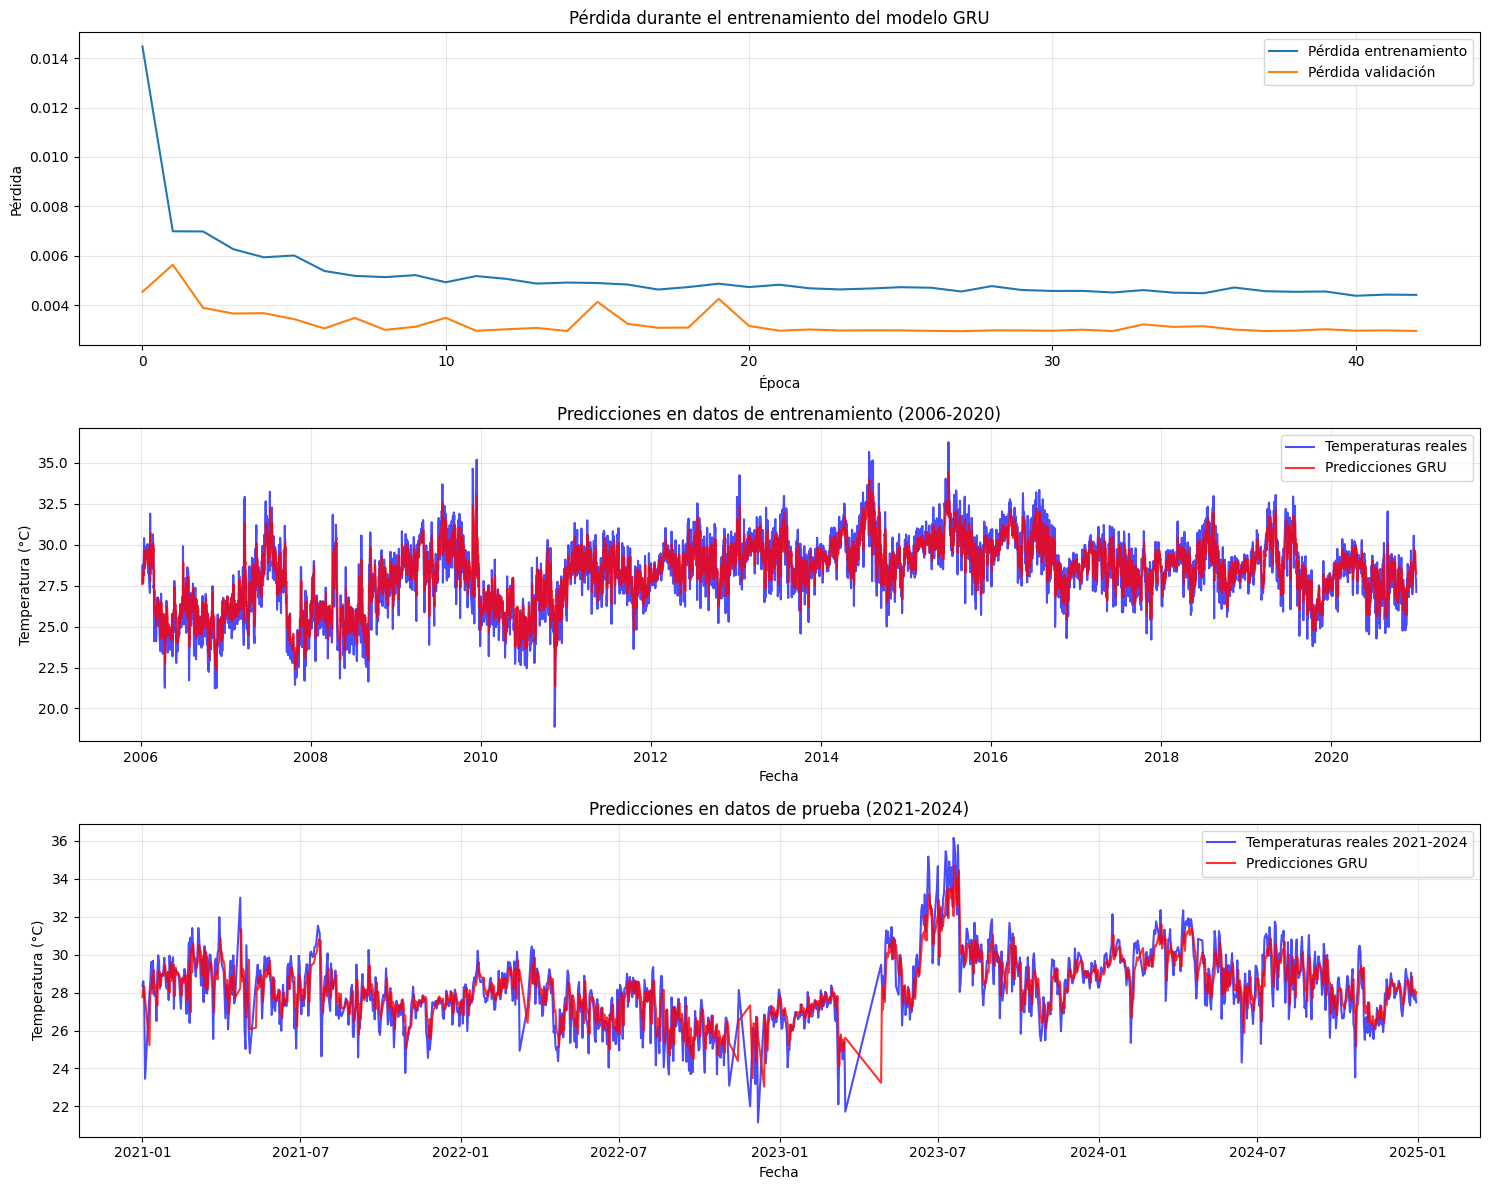

Gráficos generados correctamente


In [ ]:
# =============================================================================
# PASO 10: GRAFICAR LOS RESULTADOS
# =============================================================================

print("\n" + "=" * 70)
print("GENERANDO GRÁFICOS DE RESULTADOS")
print("=" * 70)

# Crear gráficos
plt.figure(figsize=(15, 12))

# Gráfico 1: Pérdida durante el entrenamiento
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida durante el entrenamiento del modelo GRU')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Predicciones vs datos reales (entrenamiento)
plt.subplot(3, 1, 2)
# Usar fechas reales para el eje x
train_dates = train_data['Dia_datetime'].iloc[look_back+1:look_back+1+len(y_train_actual)]
plt.plot(train_dates, y_train_actual, label='Temperaturas reales', color='blue', alpha=0.7)
plt.plot(train_dates, train_predictions_actual, label='Predicciones GRU', color='red', alpha=0.8)
plt.title('Predicciones en datos de entrenamiento (2006-2020)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 3: Predicciones vs datos reales (prueba - 2021-2024)
plt.subplot(3, 1, 3)
# Usar fechas reales para el eje x
test_dates = test_data['Dia_datetime'].iloc[:len(y_test_actual)]
plt.plot(test_dates, y_test_actual, label='Temperaturas reales 2021-2024', color='blue', alpha=0.7)
plt.plot(test_dates, test_predictions_actual, label='Predicciones GRU', color='red', alpha=0.8)
plt.title('Predicciones en datos de prueba (2021-2024)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Gráficos generados correctamente")

In [ ]:
# =============================================================================
# ANÁLISIS ADICIONAL Y RESULTADOS
# =============================================================================

print("\n" + "=" * 70)
print("ANÁLISIS DETALLADO DE RESULTADOS")
print("=" * 70)

# Crear DataFrame con resultados de predicción
results_df = pd.DataFrame({
    'Fecha': test_data['Dia_datetime'].iloc[:len(y_test_actual)],
    'Temperatura_Real': y_test_actual.flatten(),
    'Temperatura_Predicha': test_predictions_actual.flatten(),
    'Error': y_test_actual.flatten() - test_predictions_actual.flatten()
})

print("Primeras 10 predicciones vs valores reales:")
print(results_df.head(10))

# Estadísticas del error
print(f"\nESTADÍSTICAS DEL ERROR DE PREDICCIÓN (2021-2024):")
print(f"Error promedio: {results_df['Error'].mean():.2f}°C")
print(f"Desviación estándar del error: {results_df['Error'].std():.2f}°C")
print(f"Error absoluto máximo: {results_df['Error'].abs().max():.2f}°C")
print(f"Porcentaje de predicciones con error < 1°C: {(results_df['Error'].abs() < 1).mean()*100:.1f}%")
print(f"Porcentaje de predicciones con error < 2°C: {(results_df['Error'].abs() < 2).mean()*100:.1f}%")



ANÁLISIS DETALLADO DE RESULTADOS
Primeras 10 predicciones vs valores reales:
          Fecha  Temperatura_Real  Temperatura_Predicha     Error
5421 2021-01-01         28.360871             27.761206  0.599666
5422 2021-01-02         28.600001             28.245897  0.354103
5423 2021-01-03         27.482609             28.316038 -0.833429
5424 2021-01-04         23.454546             27.683817 -4.229271
5425 2021-01-09         27.941667             25.231579  2.710088
5426 2021-01-10         28.568182             28.078730  0.489453
5427 2021-01-11         29.613635             27.972679  1.640956
5428 2021-01-12         28.191305             28.852261 -0.660955
5429 2021-01-13         29.682352             27.941133  1.741219
5430 2021-01-14         28.344444             29.191872 -0.847428

ESTADÍSTICAS DEL ERROR DE PREDICCIÓN (2021-2024):
Error promedio: -0.04°C
Desviación estándar del error: 1.16°C
Error absoluto máximo: 6.23°C
Porcentaje de predicciones con error < 1°C: 69.7%
Por